#*CNN-based Image Classifier for Shoe Brand Recognition*

---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



##Data Processing


In [3]:
import pathlib
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = pathlib.Path('/content/drive/MyDrive/Nike_Adidas_converse_Shoes_image_dataset/train/')

image_size = (240, 240) # set the size of the pigure
batch_size = 32  # size of mini batch


datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the images
    rotation_range=15,  # Randomly rotate images by up to 30 degrees
    zoom_range=[0.9, 1.1],
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,  # Randomly flip images horizontally
)


# Create the dataloader for trianing
train_data_gen = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset= None
)

Found 603 images belonging to 3 classes.


In [4]:
# The same as the code in the previous block, just change the path for validation data
# I am not going to explain it again
data_dir = pathlib.Path('/content/drive/MyDrive/Nike_Adidas_converse_Shoes_image_dataset/validate')

image_size = (240, 240)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

validate_data_gen = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset= None
)

Found 90 images belonging to 3 classes.


##Custom early stop(overfitting)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

# 自定義回調類，監控 val_loss - loss
class CustomEarlyStopping(Callback):
    def __init__(self, threshold=0.2):
        super(CustomEarlyStopping, self).__init__()
        self.threshold = threshold  # 設置差值閾值

    def on_epoch_end(self, epoch, logs=None):
        # 從 logs 中獲取 loss 和 val_loss
        loss = logs.get('loss')
        val_loss = logs.get('val_loss')

        # 確保 loss 和 val_loss 存在
        if loss is None or val_loss is None:
            print("警告：無法獲取 loss 或 val_loss，請檢查模型編譯是否包含損失指標")
            return

        # 計算差值
        diff = val_loss - loss
        print(f"Epoch {epoch + 1}: val_loss - loss = {diff:.4f}")

        # 檢查是否滿足停止條件
        if diff > self.threshold:
            print(f"val_loss - loss 大於 {self.threshold}，停止訓練")
            self.model.stop_training = True

## Trainag + output training hypram & result to xlsx

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(240, 240, 3), padding='same', kernel_regularizer=l2(0.005)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (4, 4), activation='relu', padding='same', kernel_regularizer=l2(0.005)))
model.add(MaxPooling2D((4, 4)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.005)))
model.add(MaxPooling2D((5, 5)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_regularizer=l2(0.005)))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0002)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Display model summary
model.summary()

# Assuming train_data_gen and validate_data_gen are defined
# Train the model
max_epochs = 130
history = model.fit(
    train_data_gen,
    epochs=max_epochs,
    validation_data=validate_data_gen,
    callbacks=[early_stop]
)

# Dynamically extract hyperparameters
hyperparameters = {}

# Optimizer details
hyperparameters['Optimizer'] = optimizer.__class__.__name__
hyperparameters['Learning Rate'] = optimizer.learning_rate.numpy()

# Model compilation details
hyperparameters['Loss Function'] = model.loss
hyperparameters['Metrics'] = ', '.join(model.metrics_names)

# Training settings
hyperparameters['Max Epochs'] = max_epochs
hyperparameters['Early Stopping Patience'] = early_stop.patience
hyperparameters['Input Shape'] = str(model.input_shape[1:])

# Extract layer configurations
conv_layers = []
dense_layers = []
dropout_rates = []
for layer in model.layers:
    if isinstance(layer, Conv2D):
        conv_layers.append(f"[{layer.filters}, {layer.kernel_size}]")
    elif isinstance(layer, Dense):
        dense_layers.append(layer.units)
    elif isinstance(layer, Dropout):
        dropout_rates.append(layer.rate)

hyperparameters['Conv2D Layers'] = str(conv_layers)
hyperparameters['Dense Layers'] = str(dense_layers)
hyperparameters['Dropout Rates'] = str(dropout_rates)

# Convert hyperparameters to DataFrame
hyperparam_df = pd.DataFrame([hyperparameters])

# Extract training history
history_df = pd.DataFrame(history.history)

# Save to Excel
excel_file = 'model_results_dynamic.xlsx'
with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    hyperparam_df.to_excel(writer, sheet_name='Hyperparameters', index=False)
    history_df.to_excel(writer, sheet_name='Training_History', index=True)

# Plot learning curves
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Save the plot
plot_file = 'learning_curves.png'
plt.savefig(plot_file)
plt.close()

# Append a note about the plot in the Excel file
plot_note = pd.DataFrame({'Note': [f'Learning curves saved as {plot_file}']})
with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
    plot_note.to_excel(writer, sheet_name='Notes', index=False)



print(f"Results saved to {excel_file} and learning curves saved to {plot_file}")

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_89 (Conv2D)              │ (None, 240, 240, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 120, 120, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 120, 120, 32)   │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 30, 30, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,363 (1.36 MB)

 Trainable params: 355,363 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/130
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 714ms/step - accuracy: 0.3245 - loss: 2.6411 - val_accuracy: 0.3333 - val_loss: 2.5208
Epoch 2/130
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 479ms/step - accuracy: 0.3536 - loss: 2.4720 - val_accuracy: 0.4222 - val_loss: 2.3617
Epoch 3/130
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 480ms/step - accuracy: 0.3873 - loss: 2.3351 - val_accuracy: 0.4667 - val_loss: 2.2360
Epoch 4/130
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 482ms/step - accuracy: 0.3895 - loss: 2.2084 - val_accuracy: 0.4444 - val_loss: 2.1210
Epoch 5/130
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 480ms/step - accuracy: 0.4079 - loss: 2.1001 - val_accuracy: 0.4889 - val_loss: 2.0165
Epoch 6/130
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 484ms/step - accuracy: 0.4327 - loss: 1.9982 - val_accuracy: 0.4444 - val_loss: 1.9318
Epoch 7/130
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 479ms/step - accuracy: 0.4474 - loss: 1.9152 - val_accuracy: 0.3778 - val_loss: 1.8571
Epoch 8/130
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 489ms/step - accuracy: 0.4468 - loss: 1.8395 - val_acc

##Visualizing training

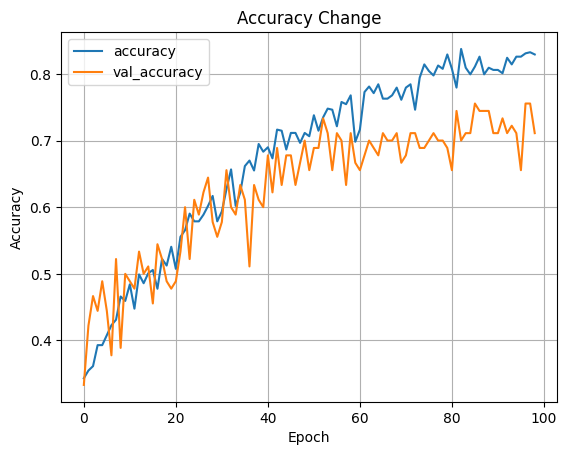

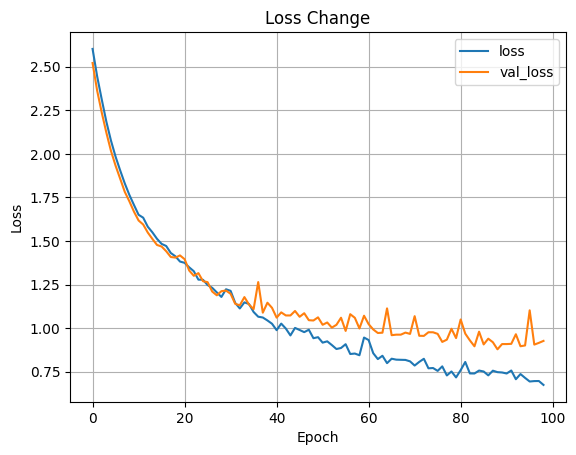

In [58]:
#visualizing training process
import matplotlib.pyplot as plt

# Accuracy 視覺化
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Change')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss 視覺化
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss Change')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

##Save model & test loading

In [59]:
model.save('13314481_best_model_.h5')

In [60]:
from tensorflow.keras.models import load_model
loaded_model = load_model('13314481_best_model_.h5')

#The following block is for loading and testing the model










In [61]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib


model = load_model('13314481_best_model_.h5') # load model


data_dir = pathlib.Path('/content/drive/MyDrive/Nike_Adidas_converse_Shoes_image_dataset/validate') #set the path of the dataset
image_size = (240, 240)
batch_size = 32

# create dataloader as the input for the model
datagen = ImageDataGenerator(rescale=1./255)
validate_data_gen = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# evaluate model
loss, accuracy = model.evaluate(validate_data_gen)
print(f"\nValidation Accuracy: {accuracy*100:.2f}%")

Found 90 images belonging to 3 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.7707 - loss: 0.8655

Validation Accuracy: 74.44%
